Connected to llm_research (Python 3.11.4)

In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

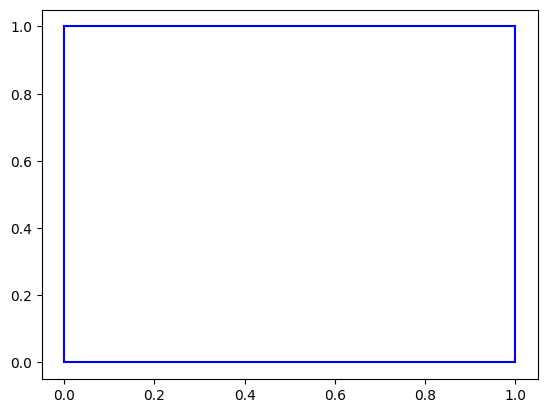

In [2]:
class Mesh:
  def __init__(self, edges: torch.Tensor):
    self.edges = edges
    self.edge_lens = torch.norm(edges[:,0] - edges[:,1], dim=1)
  
  def loop(vertices):
    edges = torch.cat([vertices[:-1], vertices[1:]],dim=1).reshape(-1, 2, 2)
    return Mesh(edges)
  
  def plot(self, c='b'):
    for edge in self.edges:
      plt.plot(*edge.T, c)
    
  def pointcloud(self,n=1000,std = 0.01):
    edges_probs = self.edge_lens/self.edge_lens.sum()
    edges = torch.multinomial(edges_probs, n, replacement=True)
    edges = self.edges[edges]
    t = torch.rand(n)
    points = edges[:,0] + t[:,None]*(edges[:,1]-edges[:,0])
    noise = torch.randn_like(points)*std
    return points + noise
  
box = Mesh.loop(torch.tensor([[0, 0], [0, 1], [1, 1],[1,0], [0,0]],dtype=torch.float32))
box.plot()

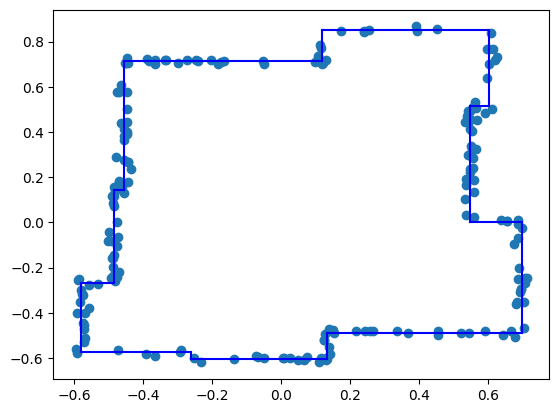

In [3]:
def random_shape():
  n = np.random.randint(3, 10)
  corners = []

  for i in range(n):
    angle = 2*np.pi*i/n + np.random.rand()*0.1
    r = np.random.rand() * 0.5 + 0.5
    corners.append(torch.tensor([np.cos(angle)*r, np.sin(angle)*r],dtype=torch.float32))

  verts = []
  corner_dir = np.random.randint(2)
  for i in range(n + 1):
    verts.append(corners[i % n])
    verts.append(torch.tensor([corners[(i+corner_dir) % n][0] , corners[(i + 1 - corner_dir) % n][1]]))

  return Mesh.loop(torch.stack(verts[:-1]))


shape = random_shape()
shape.plot()
v = shape.pointcloud(200)
plt.scatter(*v.T)

In [4]:
def gen_data(n):
  train_shapes = [random_shape() for _ in range(n)]
  x = [s.pointcloud(100) for s in train_shapes]
  y = [s.edges for s in train_shapes]
  x = torch.stack(x)
  maxverts = max([len(x) for x in y])
  assert maxverts == 18 
  y = [torch.cat([y.reshape(-1,4), torch.ones(len(y), 1)], dim=1) for y in y]
  y = torch.stack([torch.cat([y, torch.zeros(maxverts - len(y), 5)]) for y in y]).reshape(-1, maxverts*5)
  return x, y

In [5]:
from torch.nn import TransformerEncoderLayer, Linear, Sequential
from torch.optim import Adam

input_dim = 2
output_dim = 18 * 5
hidden_dim = 1024
nhead = 2
num_layers = 3
inducing_points = 18

class MAB(torch.nn.Module):
  def __init__(self, hidden_dim, nhead):
    super(MAB, self).__init__()
    self.attention = torch.nn.MultiheadAttention(hidden_dim, nhead, batch_first=True)
    self.linear = Linear(hidden_dim, hidden_dim)
  def forward(self, q, kv): 
    x = self.attention(q, kv, kv)[0] + q
    return self.linear(x).relu()

class ISAB(torch.nn.Module):
  def __init__(self, hidden_dim, nhead, inducing_points):
    super(ISAB, self).__init__()
    self.inducing_points = inducing_points
    self.mab1 = MAB(hidden_dim, nhead)
    self.mab2 = MAB(hidden_dim, nhead)
    self.I = torch.nn.Parameter(torch.randn(1,inducing_points, hidden_dim))
  def forward(self, x):
    it = self.mab1(self.I.repeat(x.shape[0],1,1), x)
    x = self.mab2(x, it)
    return x

class SetTransformer(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, nhead, num_layers):
    super(SetTransformer, self).__init__()
    self.embedding = Linear(input_dim, hidden_dim)
    self.layers = [ISAB(hidden_dim, nhead, inducing_points) for _ in range(num_layers)]
    self.adapter = Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.embedding(x)
    for layer in self.layers: x = layer(x)
    x = self.adapter(x.mean(dim=1)).reshape(-1,18,5)
    x[:,:,4] = x[:,:,4].sigmoid()
    return x

  def save(self, path): torch.save(self.state_dict(), path)
  def load(self, path): self.load_state_dict(torch.load(path))


train_x, train_y = gen_data(200)
model = SetTransformer(input_dim, hidden_dim, output_dim, nhead, num_layers)
print(model(train_x[:2]).shape)
optimizer = Adam(model.parameters(), lr=0.001)

torch.Size([2, 18, 5])


/home/service/miniconda3/envs/llm_research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from torch.nn import TransformerEncoderLayer, Linear, Sequential
from torch.optim import Adam

input_dim = 2
output_dim = 18 * 5
hidden_dim = 1024
nhead = 2
num_layers = 3
inducing_points = 18

class MAB(torch.nn.Module):
  def __init__(self, hidden_dim, nhead):
    super(MAB, self).__init__()
    self.attention = torch.nn.MultiheadAttention(hidden_dim, nhead, batch_first=True)
    self.linear = Linear(hidden_dim, hidden_dim)
  def forward(self, q, kv): 
    x = self.attention(q, kv, kv)[0] + q
    return self.linear(x).relu()

class ISAB(torch.nn.Module):
  def __init__(self, hidden_dim, nhead, inducing_points):
    super(ISAB, self).__init__()
    self.inducing_points = inducing_points
    self.mab1 = MAB(hidden_dim, nhead)
    self.mab2 = MAB(hidden_dim, nhead)
    self.I = torch.nn.Parameter(torch.randn(1,inducing_points, hidden_dim))
  def forward(self, x):
    it = self.mab1(self.I.repeat(x.shape[0],1,1), x)
    x = self.mab2(x, it)
    return x

class SetTransformer(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, nhead, num_layers):
    super(SetTransformer, self).__init__()
    self.embedding = Linear(input_dim, hidden_dim)
    self.layers = [ISAB(hidden_dim, nhead, inducing_points) for _ in range(num_layers)]
    self.adapter = Linear(hidden_dim, output_dim)

  def forward(self, x):
    x = self.embedding(x)
    for layer in self.layers: x = layer(x)
    x = self.adapter(x.mean(dim=1)).reshape(-1,18,5)
    x[:,:,4] = x[:,:,4].sigmoid()
    return x

  def save(self, path): torch.save(self.state_dict(), path)
  def load(self, path): self.load_state_dict(torch.load(path))


train_x, train_y = gen_data(200)
model = SetTransformer(input_dim, hidden_dim, output_dim, nhead, num_layers)
print(model(train_x[:2]).shape)
optimizer = Adam(model.parameters(), lr=0.001)

torch.Size([2, 18, 5])


loss:1.8317862749099731

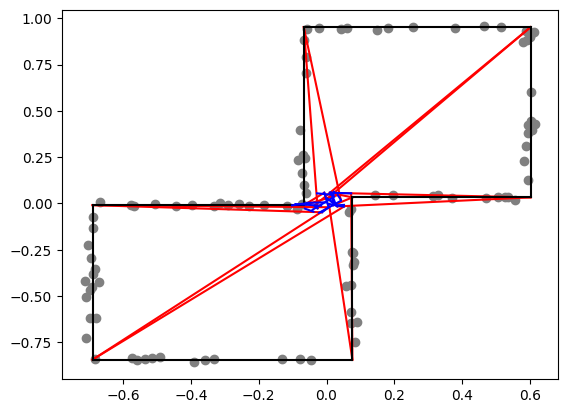

In [7]:
def loss_fn(p, y):
  p = p.reshape(-1,18,5)
  y = y.reshape(-1,18,5)

  new_y = torch.zeros_like(p)
  for i, (pshape, yshape) in enumerate(zip(p,y)):
    reordered_y = []
    for pedge in pshape:
      dists = torch.norm(pedge - yshape[:], dim=1)
      closest = dists.argmin()
      reordered_y.append(yshape[closest])
      yshape = torch.cat([yshape[:closest], yshape[closest+1:]])
    yshape = torch.stack(reordered_y)
    new_y[i] = yshape
  
  y = new_y
  mask = y[:,:,4:]
  pred_mask = p[:,:,4:]
  
  masked_dists = (p[:,:,:4] - y[:,:,:4])**2 * mask
  geom_loss = masked_dists.sum()/mask.sum()
  
  mask_loss = torch.nn.functional.binary_cross_entropy(pred_mask, mask, reduction='mean')
  return geom_loss + mask_loss, y

def step(x,y):
  optimizer.zero_grad()
  p = model(x)
  loss, reordered_y = loss_fn(p, y)
  loss.backward()
  optimizer.step()
  print(f'\rloss:{loss.item()}',end='')
  return p, reordered_y

def display(p,x,y):
  k = np.random.randint(0, len(x))
  p_edges = p[k].reshape(-1,5)[:,:4].reshape( 18, 2, 2)
  y_edges = y[k].reshape(-1,5)[:,:4].reshape( 18, 2, 2)
  pmask = p[k].reshape(-1,5)[:,4:].reshape( 18, 1)



  for edge, yedge in zip(p_edges, y_edges):
    if yedge.sum() != 0:
      plt.plot([edge[0,0], yedge[0,0]], [edge[0,1], yedge[0,1]], c='red')
      plt.plot([edge[1,0], yedge[1,0]], [edge[1,1], yedge[1,1]], c='red')

    
  for edge in y_edges: plt.plot(*edge.T, c='black')
  for edge in p_edges: plt.plot(*edge.T, c='blue')
  
  plt.scatter(*x[k].T, c='gray')

p,newy=step(train_x,train_y)
display(p.detach(),train_x,newy)

loss:1.7852983474731445
epoch 0


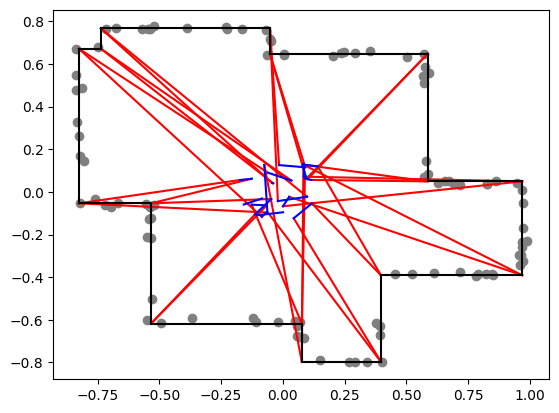

loss:1.2036108970642098
epoch 10


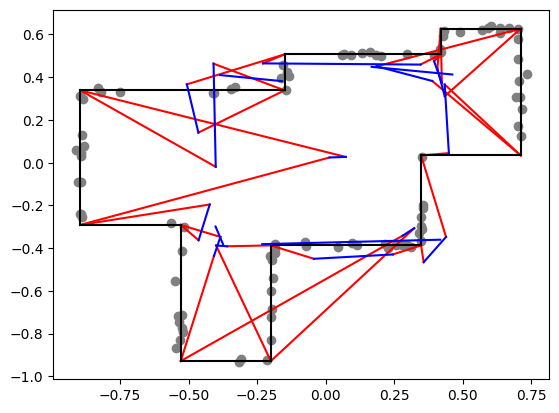

loss:1.0515766143798828
epoch 20


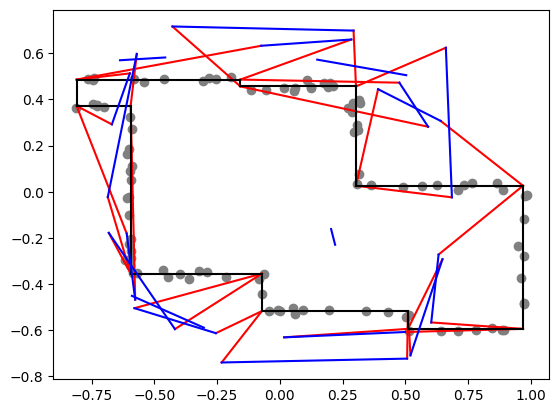

loss:0.9999151229858398
epoch 30


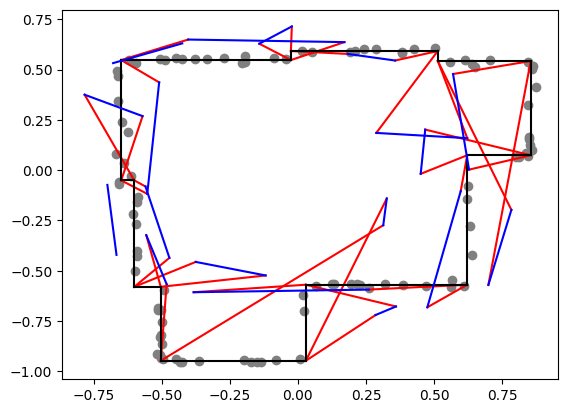

loss:0.9164270162582397
epoch 40


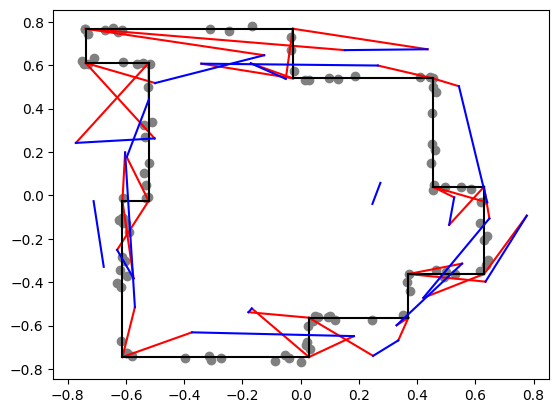

loss:0.8500156998634338
epoch 50


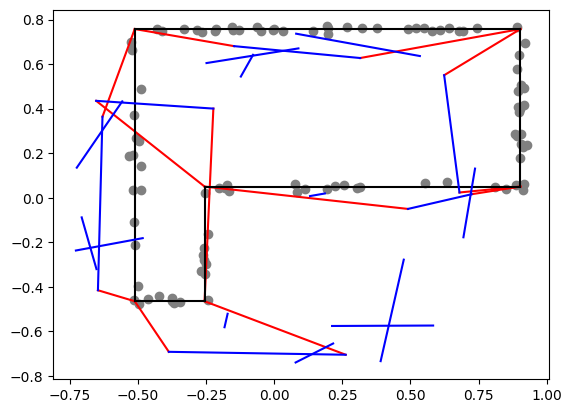

loss:0.8051259517669678
epoch 60


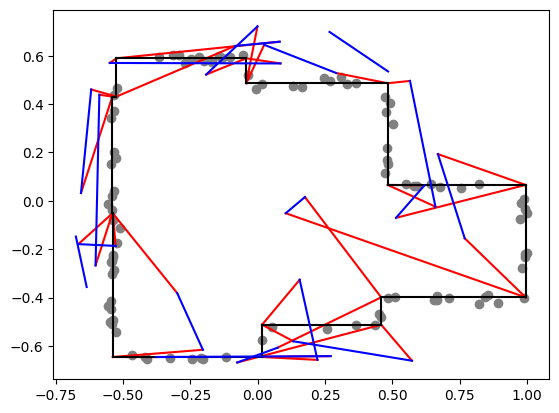

loss:0.7516012191772461
epoch 70


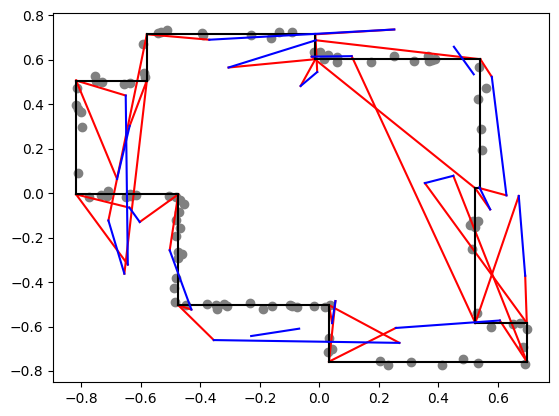

loss:0.7689944505691528
epoch 80


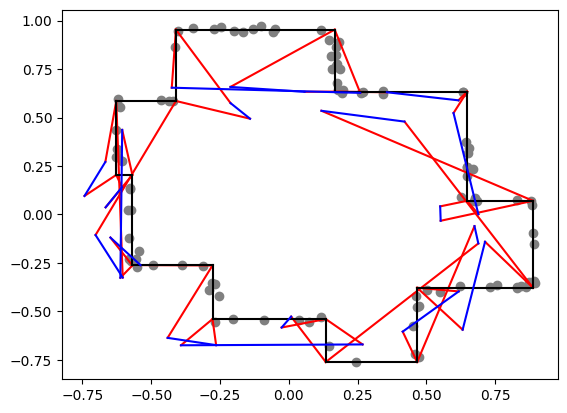

loss:0.7711576819419861
epoch 90


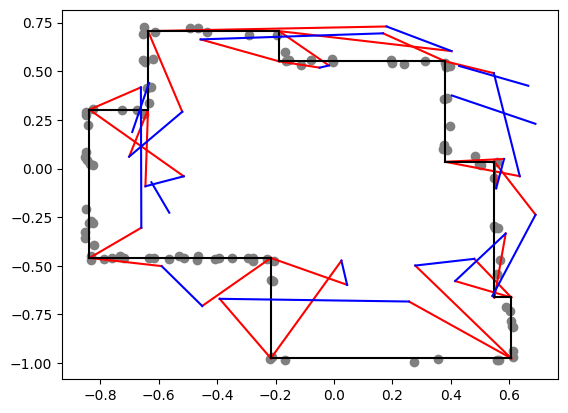

loss:0.7421125173568726
epoch 100


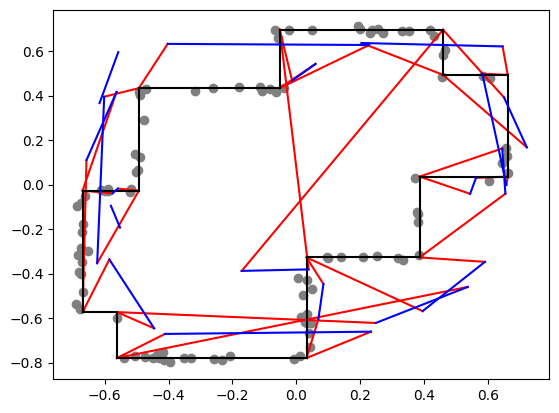

loss:0.7124516963958744
epoch 110


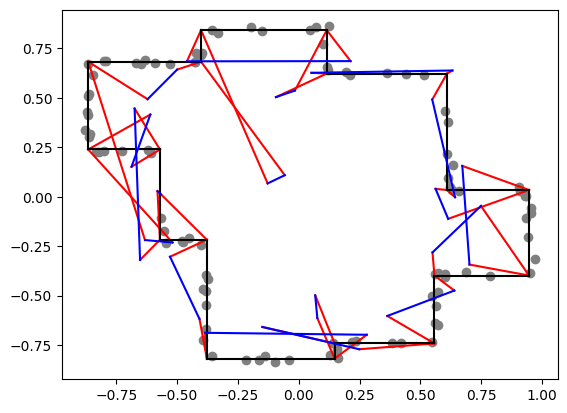

loss:0.6756434440612793
epoch 120


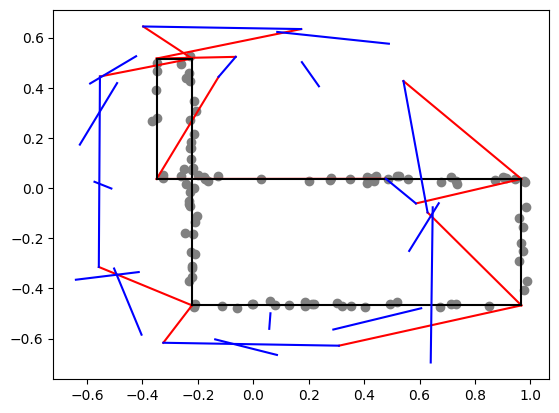

loss:0.6645511388778687
epoch 130


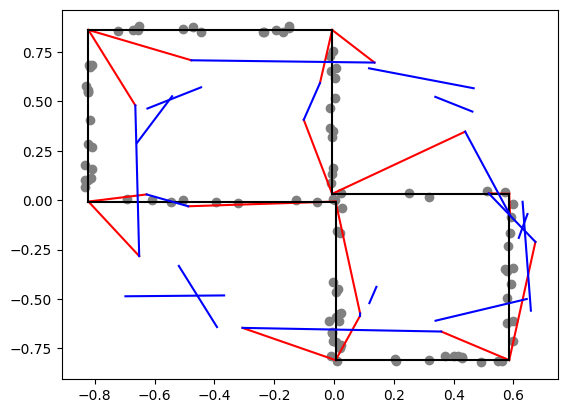

loss:0.6733258962631226
epoch 140


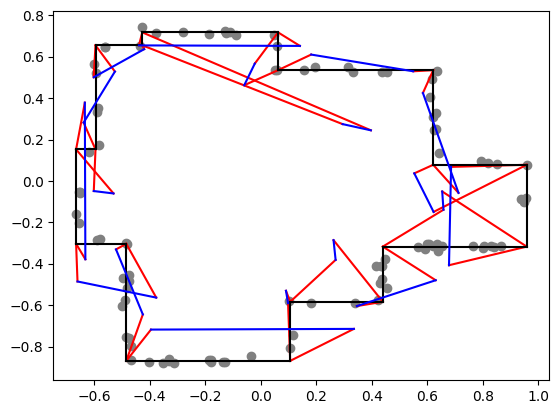

loss:0.6573025584220886
epoch 150


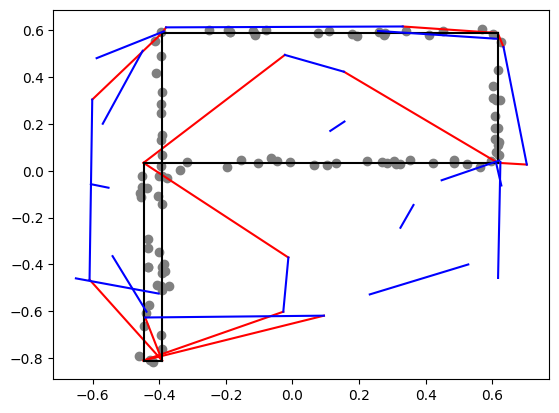

loss:0.6440801620483398

In [8]:
try:
  for i in range(500):
    train_x, train_y = gen_data(200)
    _,newy = step(train_x,train_y)
    if i % 10 == 0:
      print(f'\nepoch {i}')
      with torch.no_grad(): p = model.train(False).forward(train_x)
      display(p,train_x,newy)
      plt.show()
except: pass

In [9]:
torch.ones(10).device

device(type='cpu')